In [228]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import RFE

from sklearn import metrics

import matplotlib.pyplot as plt

logging.basicConfig(level = logging.INFO)

In [231]:
class Dataset2:
    def __init__(self, par_dir, data_tag, kfold=5):
        
        wdir = os.path.join(par_dir, data_tag)
        
        gene = os.path.join(wdir,"gene.csv")
        labels = os.path.join(wdir,"labels.csv")
                
        print("loading dataset:", end=" ")
        print(data_tag, end=" dataset\n")
        with open(gene, 'r') as f:
            features = []
            for l in f.readlines():
                if len(l) > 1:
                    features.append(np.array(l.split(",")))

        lbl = []
        with open(labels, 'r') as f:
            for l in f.readlines():
                lbl.append(int(l[0])-1)
        self.X_train = []
        self.X_test = [] 
        self.Y_train = []
        self.Y_test = []
        for i in range(kfold):
            ret = train_test_split(features, lbl, test_size =  0.2, stratify = lbl)
            self.X_train.append(ret[0]) 
            self.X_test.append(ret[1])
            self.Y_train.append(ret[2]) 
            self.Y_test.append(ret[3])
            standard_scaler = StandardScaler()
            standard_scaler.fit(self.X_train[i])
            self.X_train[i] = standard_scaler.transform(self.X_train[i])
            self.X_test[i] = standard_scaler.transform(self.X_test[i])

In [232]:
data_dict = dict()
dataset_wrk = ['breast', 'lung'] 
for d in dataset_wrk:
    data_dict[d] = Dataset2("/home/ankit/Documents/sp19/cs466/project/tasks/cancer-classification-master/Data", d) 

loading dataset: breast dataset
loading dataset: lung dataset


In [233]:
m_list = ['knn','lr','svm','knn','rf','nb']

In [235]:
def calculate_accuracies(X_train, Y_train, X_test, Y_test, model, feature_indices = None):
    if feature_indices is not None:
        X_train = X_train[:, feature_indices]
        X_test = X_test[:, feature_indices]

    train_pred_y = model.predict(X_train)
    test_pred_y = model.predict(X_test)

    train_accuracy = metrics.accuracy_score(y_pred=train_pred_y, y_true=Y_train)
    test_accuracy = metrics.accuracy_score(y_pred=test_pred_y, y_true=Y_test)

    return train_accuracy, test_accuracy

In [308]:
def feat_sel(data, nf, mode =None, model_opt="lr"):
    num_fold = len(data.Y_train)
    ret = []
    if mode is None:
        for i in range(num_fold):
            ret.append(None)
    if mode == "kbest":
        for i in range(num_fold):
            ret.append(SelectKBest(k=nf, score_func=f_classif).fit(data.X_train[i], data.Y_train[i]).get_support(indices=True))
    else: 
        for i in range(num_fold):
            lr_ext = LogisticRegression(solver='lbfgs')
            rfe = RFE(lr_ext, nf, step = 0.1)
            ret.append(rfe.fit(data.X_train[i], data.Y_train[i]).get_support(indices=True))
    return ret


def rfmodel(data, nt = 20, fid = 0, feat=None):
    model=RandomForestClassifier(n_estimators=nt)
    if feat is None:
        model.fit(data.X_train[fid], data.Y_train[fid])
    else:
        model.fit(data.X_train[fid][:,feat], data.Y_train[fid])
    return model


def lrmodel(data,fid = 0, feat=None):
    model=LogisticRegression(solver='lbfgs')
    if feat is None:
        model.fit(data.X_train[fid], data.Y_train[fid])
    else:
        model.fit(data.X_train[fid][:,feat], data.Y_train[fid])
    return model

def knnmodel(data, kn = 5, fid = 0, feat=None):
    model = KNeighborsClassifier(n_neighbors=kn)
    if feat is None:
        model.fit(data.X_train[fid], data.Y_train[fid])
    else:
        model.fit(data.X_train[fid][:,feat], data.Y_train[fid])
    return model

def nbmodel(data, fid = 0, feat=None):
    kf = len(data.X_train)
    model = GaussianNB()
    if feat is None:
        model.fit(data.X_train[fid], data.Y_train[fid])
    else:
        model.fit(data.X_train[fid][:,feat], data.Y_train[fid])
    return model

def svmmodel(data, fid = 0, feat=None):
    kf = len(data.X_train)
    model = svm.SVC(C=1.0, kernel='rbf', gamma=0.01)
    if feat is None:
        model.fit(data.X_train[fid], data.Y_train[fid])
    else:
        model.fit(data.X_train[fid][:,feat], data.Y_train[fid])
    return model

def automod(data, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for nf in range(5, 301, 20):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[nf] = 0.0
        test_scores[nf] = 0.0
        for i in range(kf):
            if mode =='nb':
                model = nbmodel(data, fid=i, feat=bfeat[i])
            if mode =='lr':
                model = lrmodel(data, fid=i, feat=bfeat[i])
            if mode =='rf':
                model = rfmodel(data, fid=i, feat=bfeat[i])
            if mode =='svm':
                model = svmmodel(data, fid=i, feat=bfeat[i])
            if mode =='knn':
                model = knnmodel(data, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[nf] += train_acc
            test_scores[nf] += test_acc
        train_scores[nf]/=kf
        test_scores[nf]/=kf
    return train_scores, test_scores

In [264]:
train_scores = dict()
test_scores = dict()

for d in data_dict:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automod(data, mode=m)

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr


In [265]:
import pickle

f = open("dump_trainscores_kbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_testscores_kbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

breast:


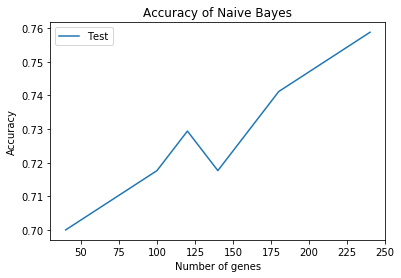

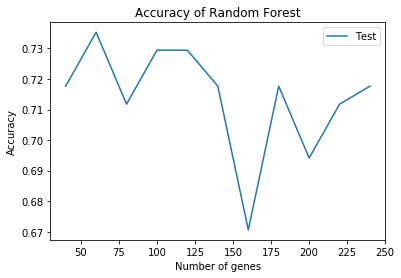

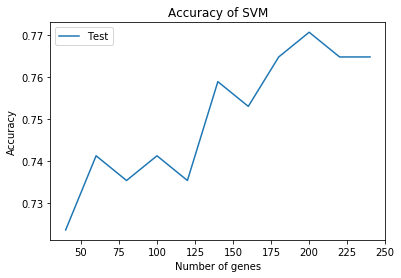

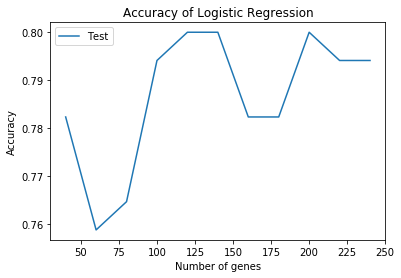

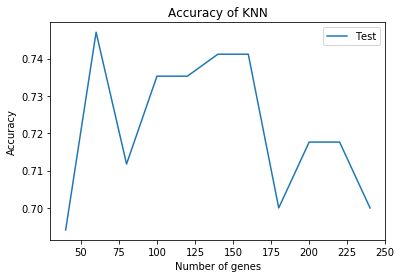

lung:


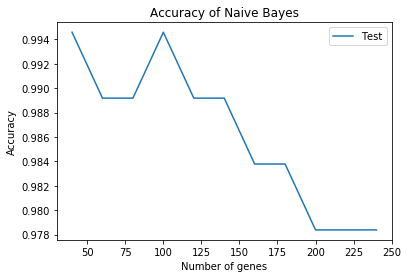

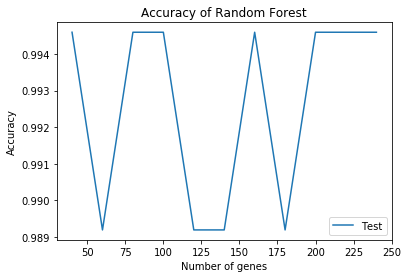

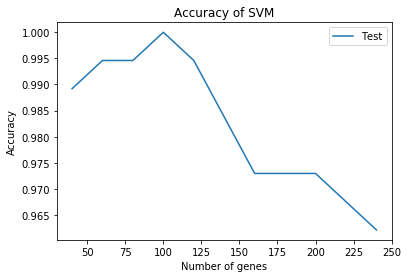

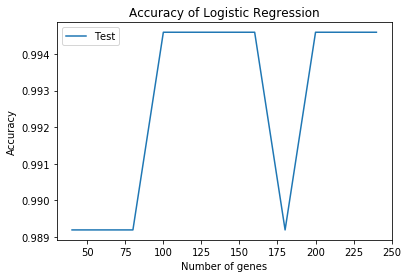

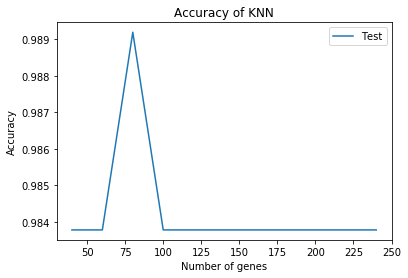

In [266]:
plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

In [264]:
train_scores = dict()
test_scores = dict()

for d in data_dict:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automod(data, mode=m, f_sel="recursive")

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr


In [265]:
import pickle

f = open("dump_trainscores_kbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_testscores_kbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

breast:


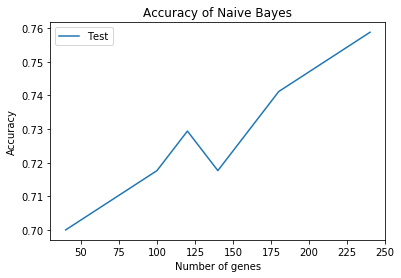

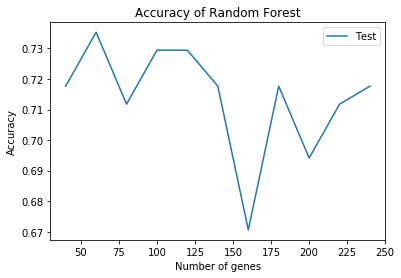

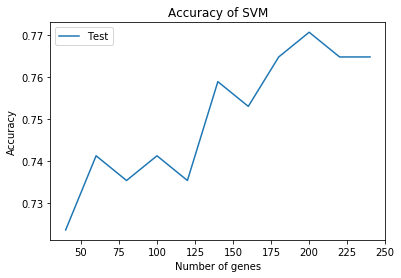

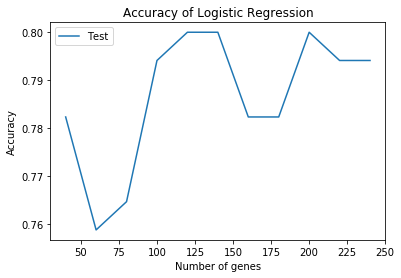

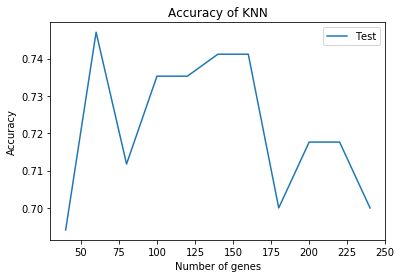

lung:


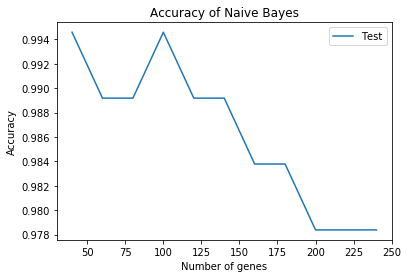

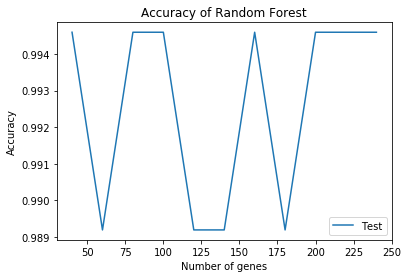

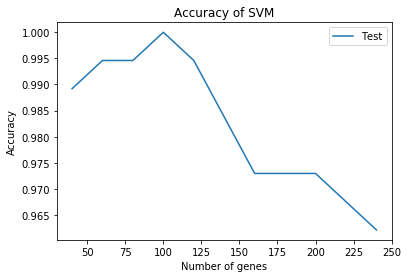

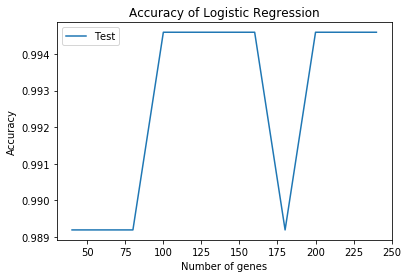

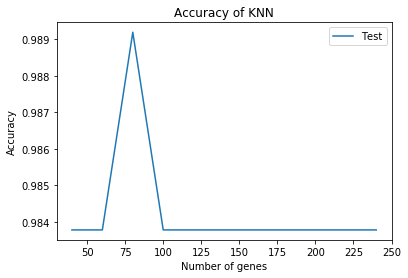

In [266]:
plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr
breast:


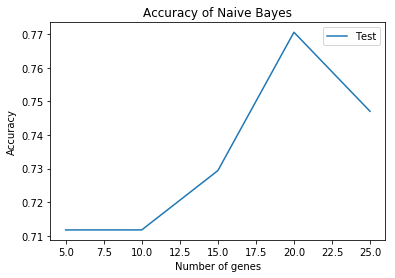

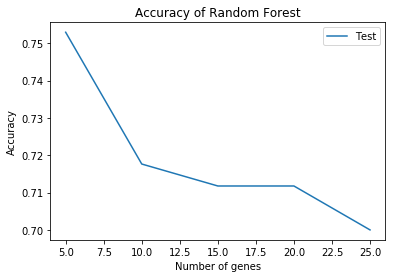

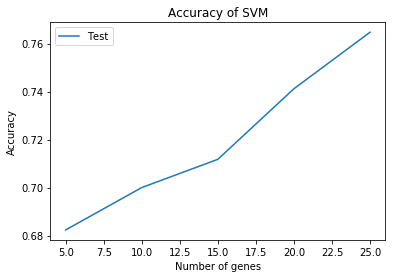

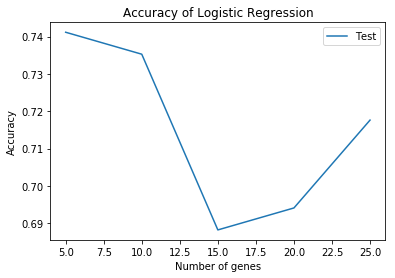

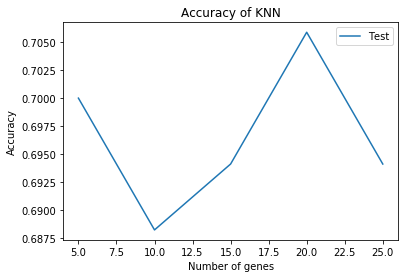

lung:


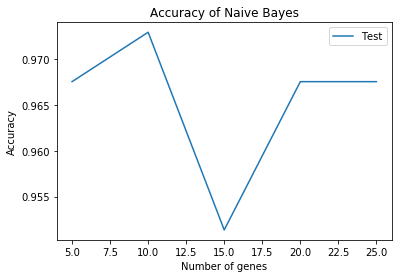

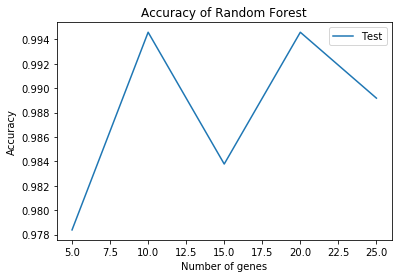

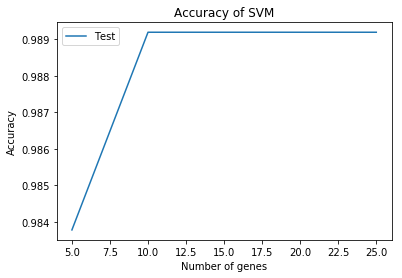

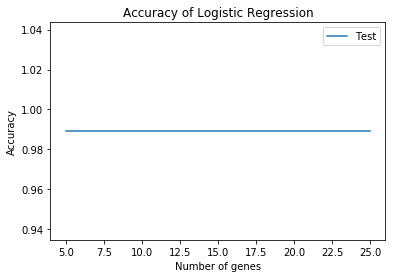

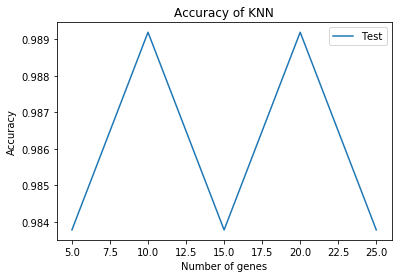

In [274]:
def automodrec(data, mode= 'lr', f_sel="recbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for nf in range(5, 51, 5):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[nf] = 0.0
        test_scores[nf] = 0.0
        for i in range(kf):
            if mode =='nb':
                model = nbmodel(data, fid=i, feat=bfeat[i])
            if mode =='lr':
                model = lrmodel(data, fid=i, feat=bfeat[i])
            if mode =='rf':
                model = rfmodel(data, fid=i, feat=bfeat[i])
            if mode =='svm':
                model = svmmodel(data, fid=i, feat=bfeat[i])
            if mode =='knn':
                model = knnmodel(data, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[nf] += train_acc
            test_scores[nf] += test_acc
        train_scores[nf]/=kf
        test_scores[nf]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automodrec(data, mode=m)

import pickle

f = open("dump_trainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_testscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

In [277]:
len(data_dict['lung'].X_test[0])

37

breast:
	5
	20
	50
lung:
	5
	20
	50
breast:


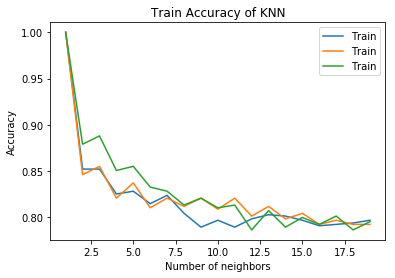

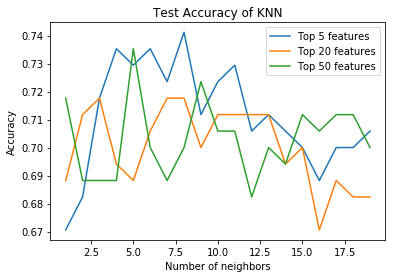

lung:


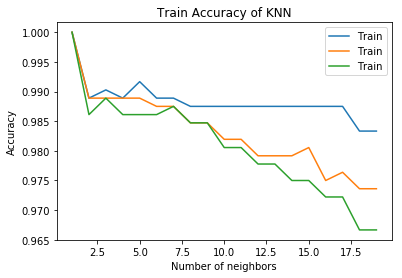

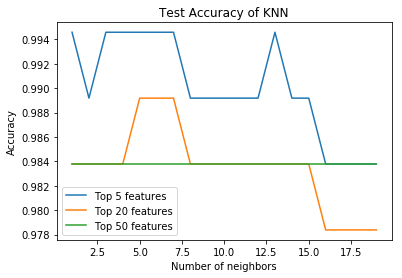

In [282]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in range(1,20):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    for nf in [5,20,50]:
        print("\t"+str(nf),end="\n")
        train_scores[d][nf], test_scores[d][nf]  = autoknn(data, nf, mode='knn')

import pickle

f = open("dump_knntrainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_knntestscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

for d in data_dict:
    print(d,end=":\n")
    data = data_dict[d]
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(train_scores[d][nf].keys()), list(train_scores[d][nf].values()), label = "Train")
    plt.title("Train Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_train_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(test_scores[d][nf].keys()), list(test_scores[d][nf].values()), label = "Top "+str(nf) + " features")
    plt.title("Test Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_test_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();

In [285]:
data_dict2 = dict()
dataset_wrk = ['breast', 'lung'] 
for d in dataset_wrk:
    data_dict2[d] = Dataset2("/home/ankit/Documents/sp19/cs466/project/tasks/cancer-classification-master/Data", d, kfold = 10) 

loading dataset: breast dataset
loading dataset: lung dataset


breast:
	5
	20
	50
lung:
	5
	20
	50
breast:


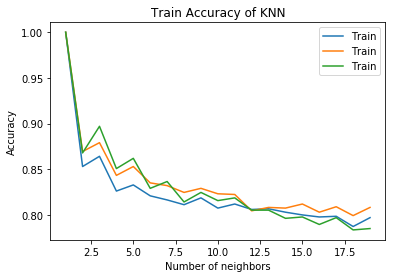

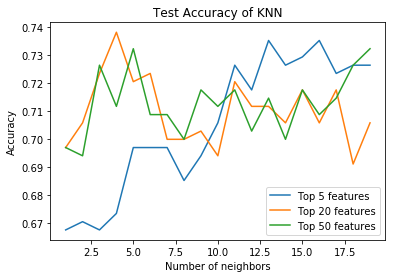

lung:


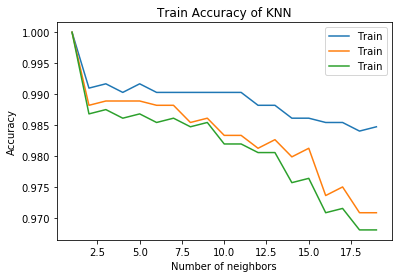

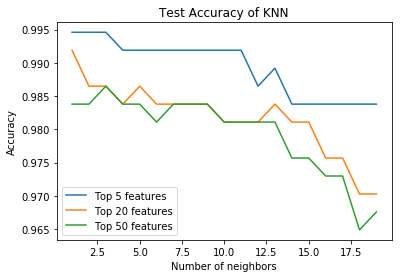

In [286]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in range(1,20):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict2:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    for nf in [5,20,50]:
        print("\t"+str(nf),end="\n")
        train_scores[d][nf], test_scores[d][nf]  = autoknn(data, nf, mode='knn')

import pickle

f = open("dump_10knntrainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10knntestscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

for d in data_dict2:
    print(d,end=":\n")
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(train_scores[d][nf].keys()), list(train_scores[d][nf].values()), label = "Train")
    plt.title("Train Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_train_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(test_scores[d][nf].keys()), list(test_scores[d][nf].values()), label = "Top "+str(nf) + " features")
    plt.title("Test Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_test_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();

In [292]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in [5,10,20]:
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
        #print(train_scores[kn],test_scores[kn])
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    print(autoknn(data, nf, mode='knn', f_sel=None))



breast:
({5: 0.6917910447761193, 10: 0.6641791044776121, 20: 0.6641791044776121}, {5: 0.6558823529411766, 10: 0.6470588235294119, 20: 0.6470588235294119})
lung:
({5: 0.9222222222222222, 10: 0.8798611111111111, 20: 0.83125}, {5: 0.9243243243243244, 10: 0.8864864864864865, 20: 0.8513513513513512})


In [296]:
def autonb(data, nf, mode= 'nb', f_sel="kbest"):
    kf = len(data.X_train)
    bfeat = feat_sel(data, nf, mode =f_sel)
    train_scores = 0.0
    test_scores = 0.0
    for i in range(kf):
        if mode =='nb':
            model = nbmodel(data, fid=i, feat=bfeat[i])
        train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
        train_scores += train_acc
        test_scores += test_acc
    train_scores/=kf
    test_scores/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    print(autonb(data, nf, mode='nb', f_sel=None))



breast:
(0.8231343283582089, 0.6882352941176471)
lung:
(1.0, 0.9891891891891891)


In [303]:
train_scores = dict()
test_scores = dict()

for d in data_dict2:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automod(data, mode=m)

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr


In [306]:
import pickle

f = open("dump_10trainscores_kbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_kbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

breast:


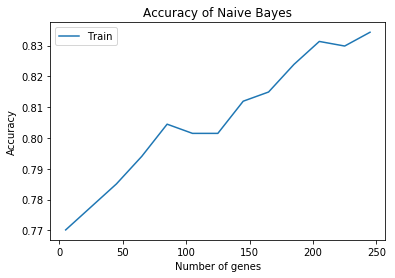

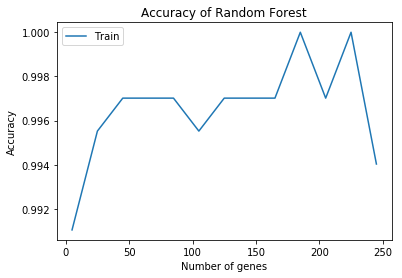

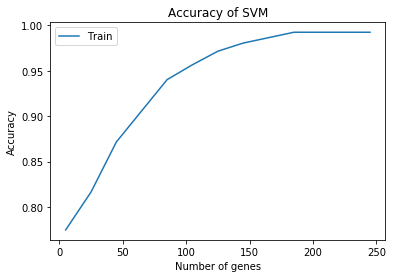

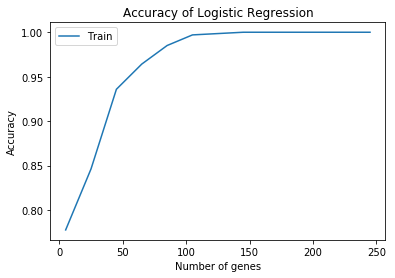

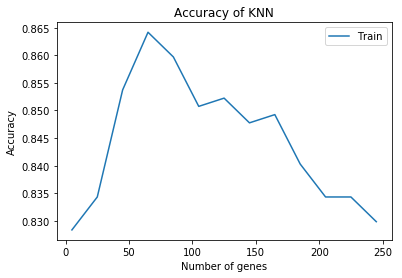

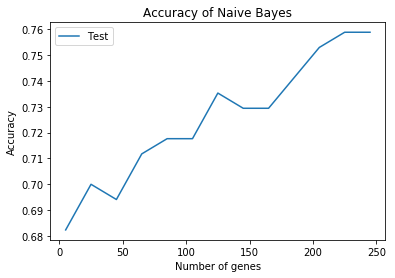

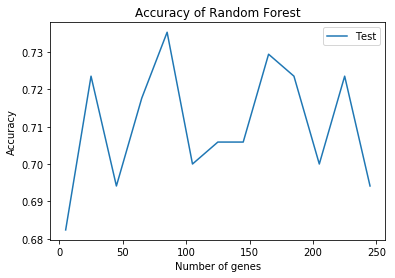

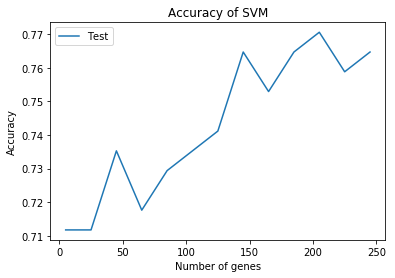

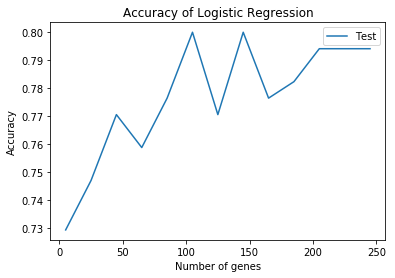

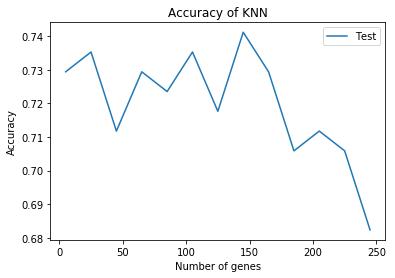

lung:


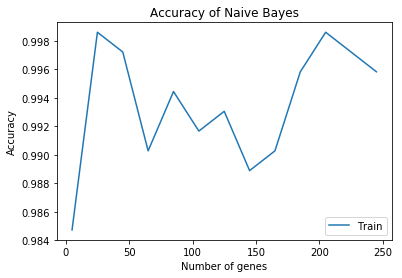

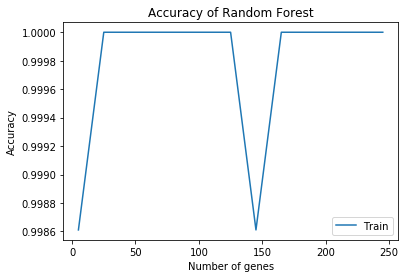

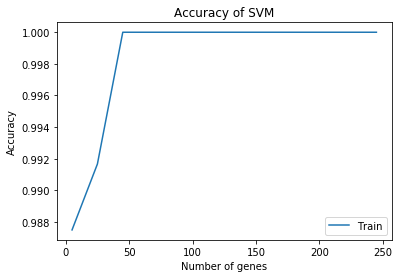

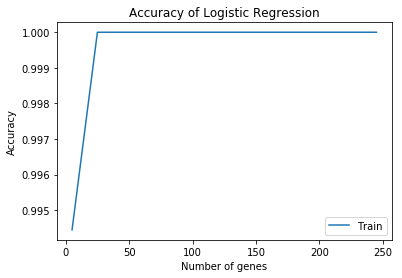

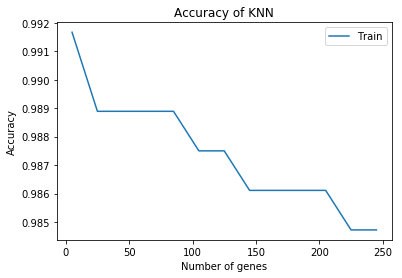

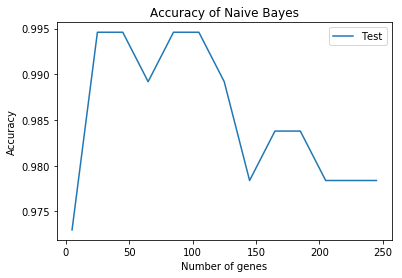

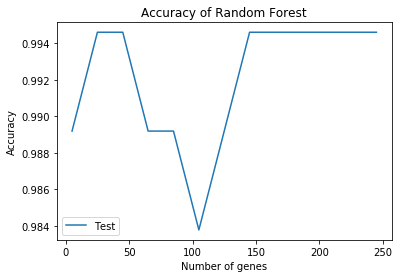

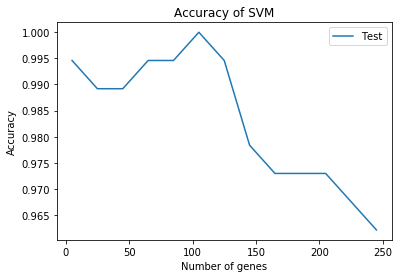

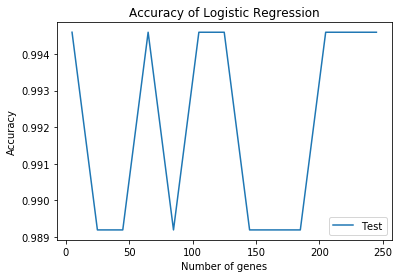

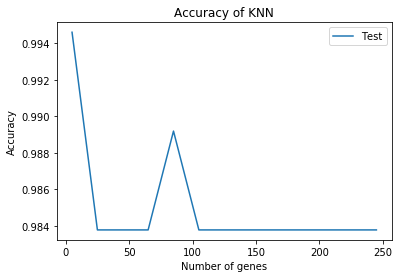

In [307]:
plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(train_scores[d][m].keys()), list(train_scores[d][m].values()), label = "Train")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

In [311]:
train_scores = dict()
test_scores = dict()

for d in data_dict2:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automod(data, mode=m)

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr


breast:


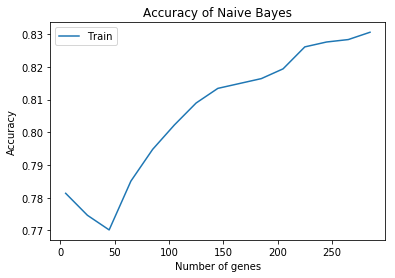

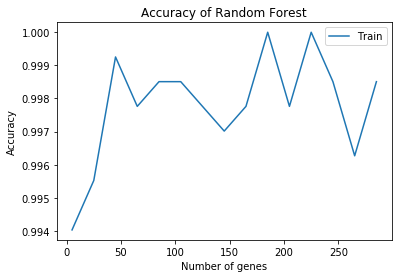

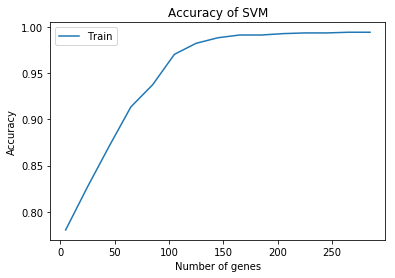

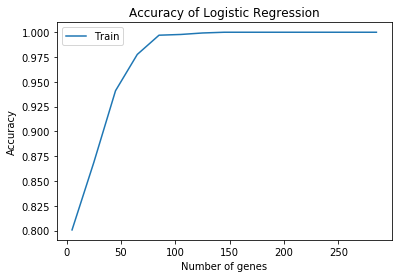

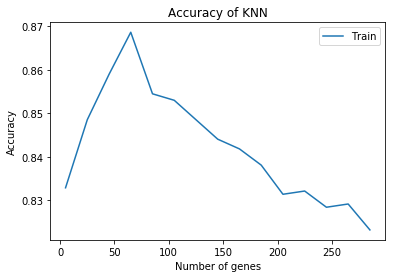

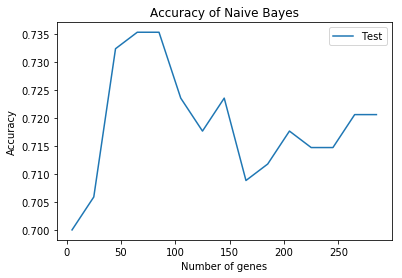

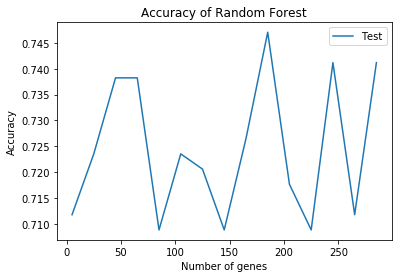

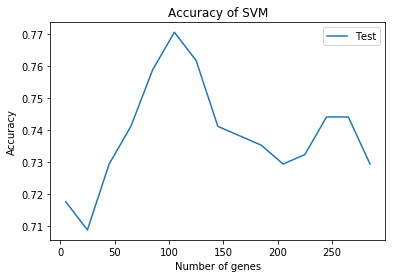

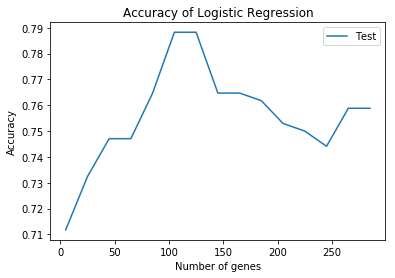

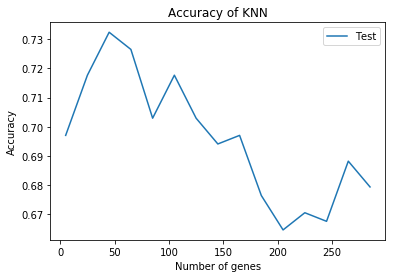

lung:


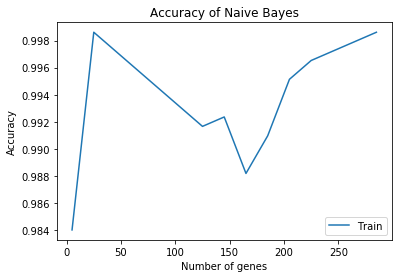

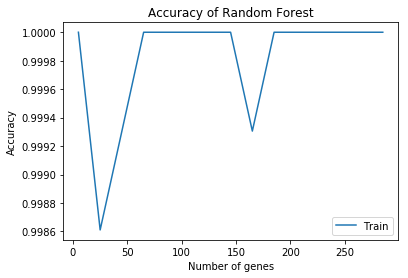

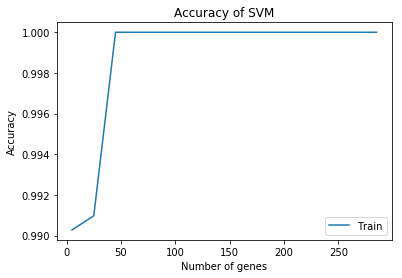

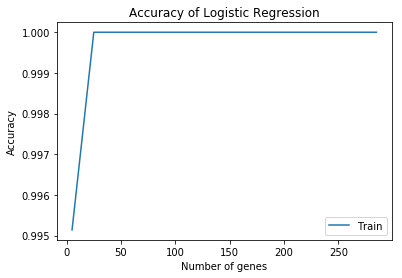

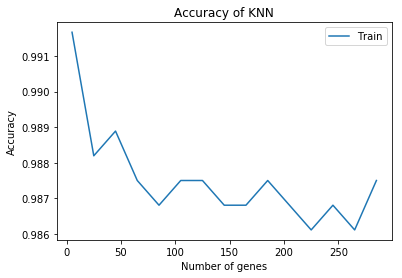

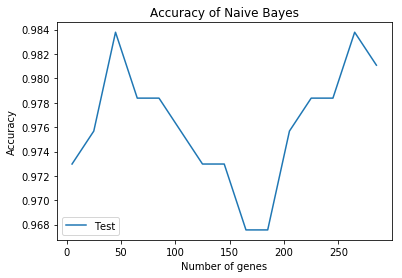

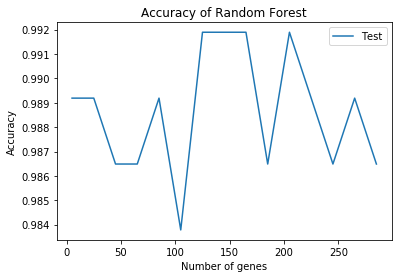

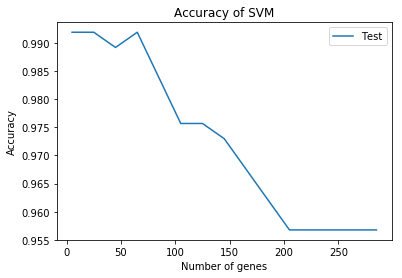

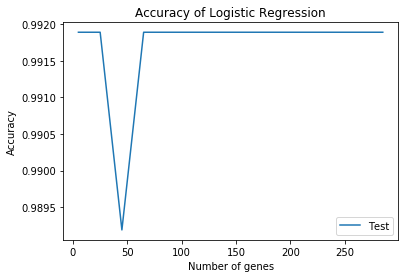

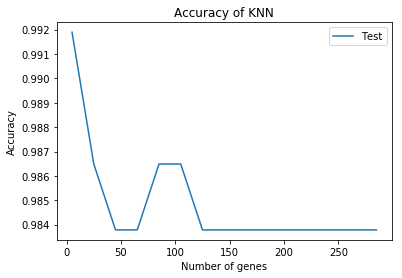

In [312]:
import pickle

f = open("dump_10trainscores_kbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_kbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(train_scores[d][m].keys()), list(train_scores[d][m].values()), label = "Train")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/test_")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/test_")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr
breast:


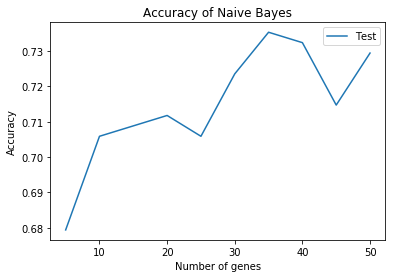

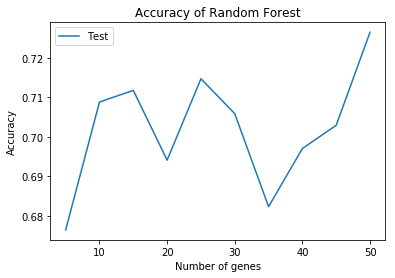

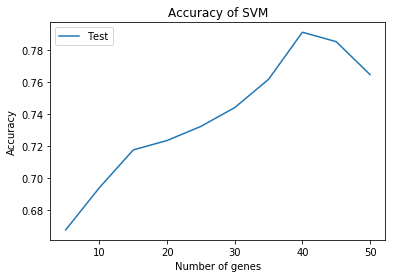

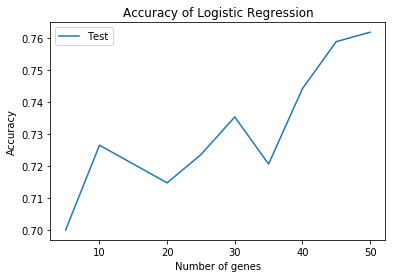

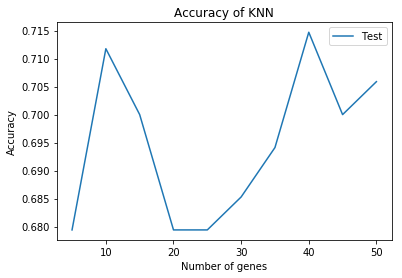

lung:


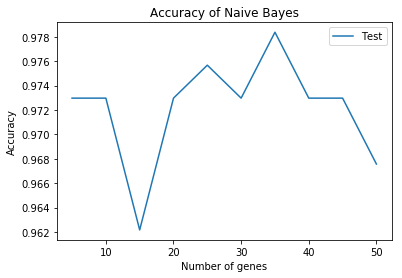

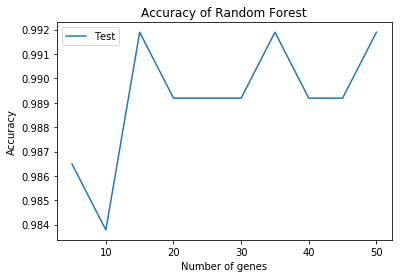

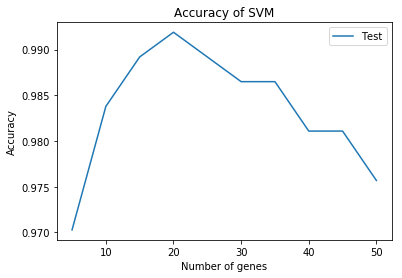

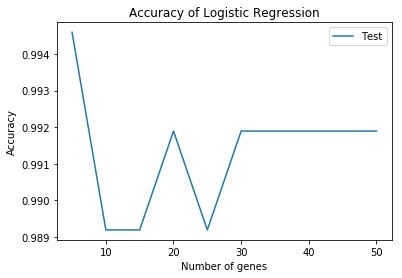

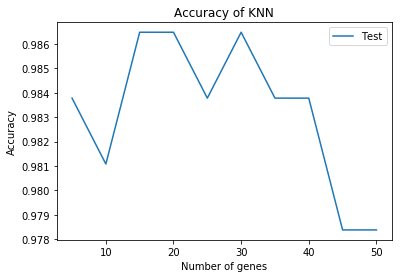

In [313]:
def automodrec(data, mode= 'lr', f_sel="recbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for nf in range(5, 51, 5):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[nf] = 0.0
        test_scores[nf] = 0.0
        for i in range(kf):
            if mode =='nb':
                model = nbmodel(data, fid=i, feat=bfeat[i])
            if mode =='lr':
                model = lrmodel(data, fid=i, feat=bfeat[i])
            if mode =='rf':
                model = rfmodel(data, fid=i, feat=bfeat[i])
            if mode =='svm':
                model = svmmodel(data, fid=i, feat=bfeat[i])
            if mode =='knn':
                model = knnmodel(data, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[nf] += train_acc
            test_scores[nf] += test_acc
        train_scores[nf]/=kf
        test_scores[nf]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict2:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automodrec(data, mode=m)

import pickle

f = open("dump_10trainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

breast:
	knn
	nb
	rf
	svm
	lr
lung:
	knn
	nb
	rf
	svm
	lr
breast:


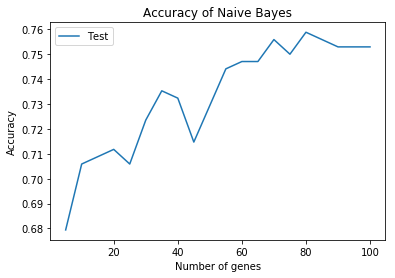

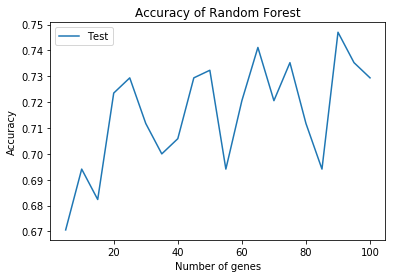

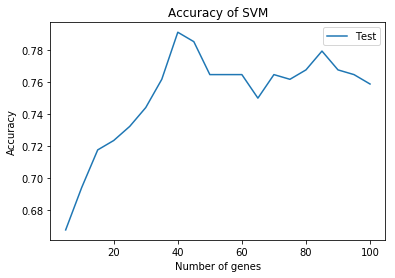

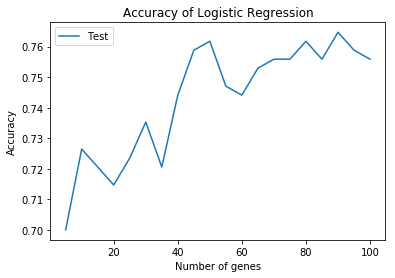

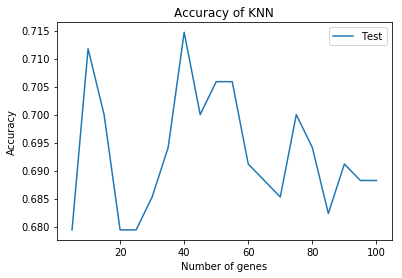

lung:


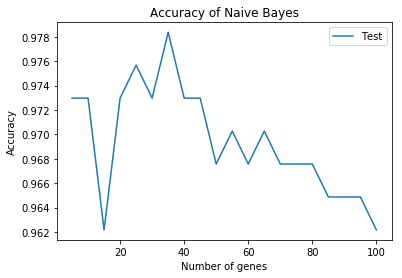

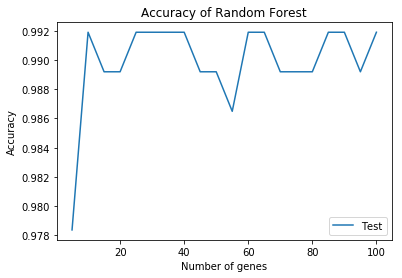

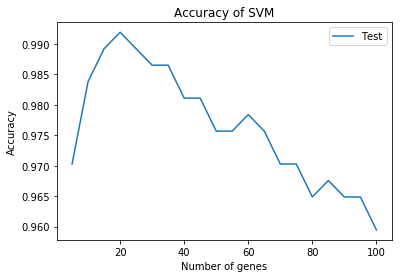

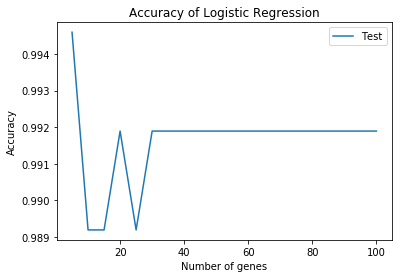

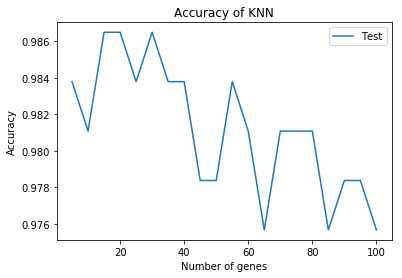

In [315]:
def automodrec(data, mode= 'lr', f_sel="recbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for nf in range(5, 105, 5):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[nf] = 0.0
        test_scores[nf] = 0.0
        for i in range(kf):
            if mode =='nb':
                model = nbmodel(data, fid=i, feat=bfeat[i])
            if mode =='lr':
                model = lrmodel(data, fid=i, feat=bfeat[i])
            if mode =='rf':
                model = rfmodel(data, fid=i, feat=bfeat[i])
            if mode =='svm':
                model = svmmodel(data, fid=i, feat=bfeat[i])
            if mode =='knn':
                model = knnmodel(data, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[nf] += train_acc
            test_scores[nf] += test_acc
        train_scores[nf]/=kf
        test_scores[nf]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict2:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automodrec(data, mode=m)

import pickle

f = open("dump_10trainscores_recbestnew.pkl_new","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_recbestnew.pkl_new","wb")
pickle.dump(test_scores,f)

f.close()

plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict2:
    print(d,end=":\n")
    data = data_dict2[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

In [316]:
data_dict3 = dict()
dataset_wrk_new = ['prostate'] 
for d in dataset_wrk_new:
    data_dict3[d] = Dataset2("/home/ankit/Documents/sp19/cs466/project/tasks/cancer-classification-master/Data", d, kfold=10) 
    
    


loading dataset: prostate dataset


prostate:
	knn
	nb
	rf
	svm
	lr
prostate:


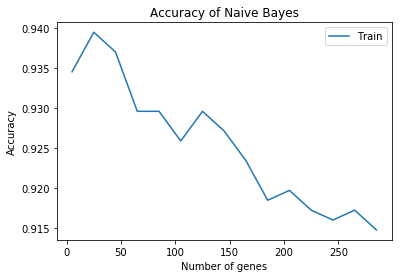

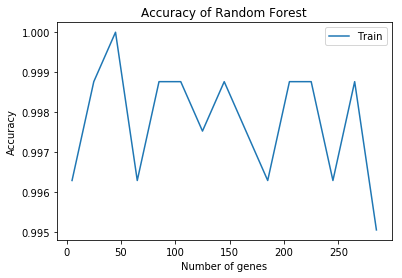

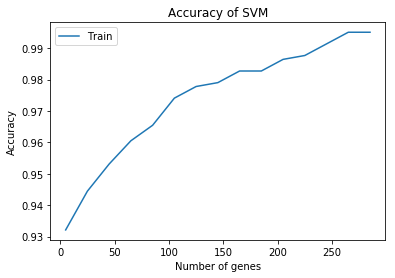

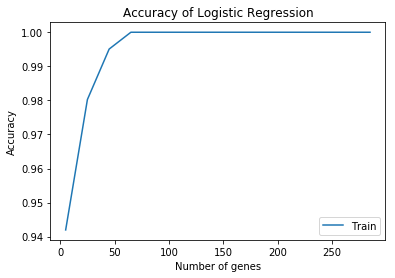

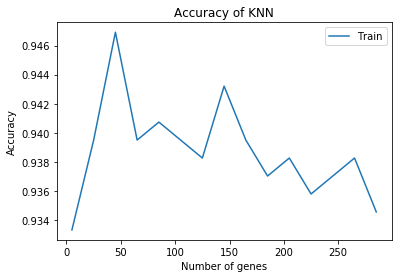

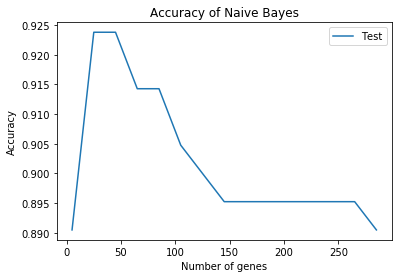

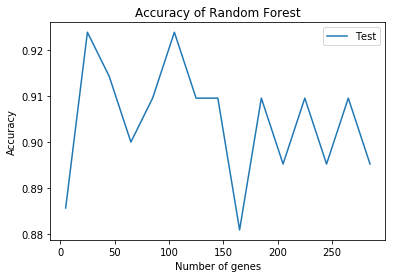

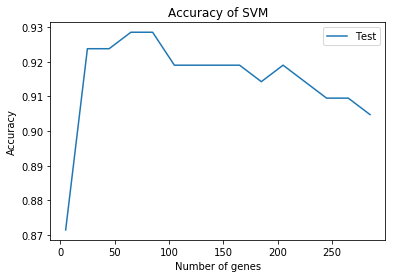

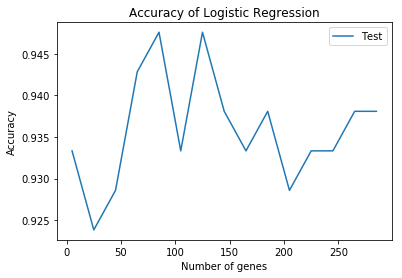

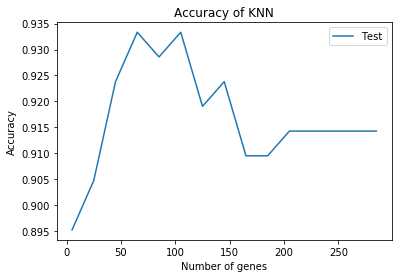

In [317]:
train_scores = dict()
test_scores = dict()

for d in data_dict3:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automod(data, mode=m)


import pickle

f = open("dump_10trainscores_kbest_prost.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_kbest_prost.pkl","wb")
pickle.dump(test_scores,f)

f.close()


plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict3:
    print(d,end=":\n")
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(train_scores[d][m].keys()), list(train_scores[d][m].values()), label = "Train")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/train_")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/test_")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

prostate:
	knn
	nb
	rf
	svm
	lr
prostate:


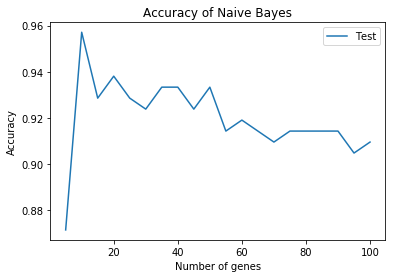

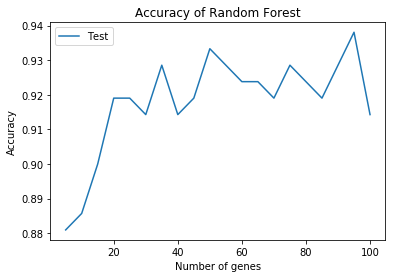

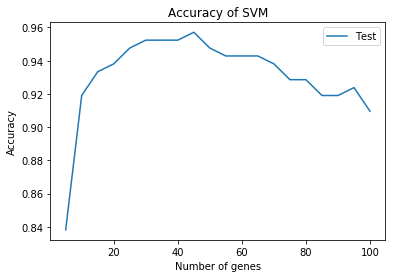

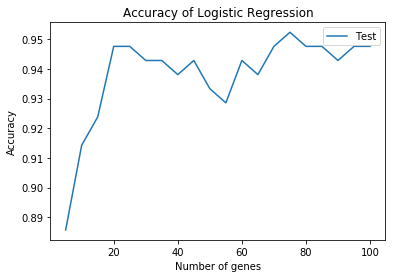

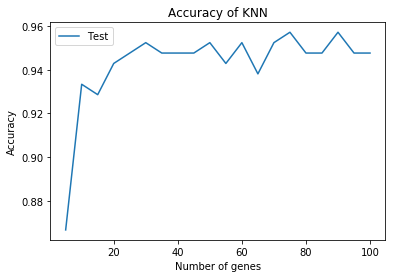

In [319]:
def automodrec(data, mode= 'lr', f_sel="recbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for nf in range(5, 105, 5):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[nf] = 0.0
        test_scores[nf] = 0.0
        for i in range(kf):
            if mode =='nb':
                model = nbmodel(data, fid=i, feat=bfeat[i])
            if mode =='lr':
                model = lrmodel(data, fid=i, feat=bfeat[i])
            if mode =='rf':
                model = rfmodel(data, fid=i, feat=bfeat[i])
            if mode =='svm':
                model = svmmodel(data, fid=i, feat=bfeat[i])
            if mode =='knn':
                model = knnmodel(data, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[nf] += train_acc
            test_scores[nf] += test_acc
        train_scores[nf]/=kf
        test_scores[nf]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict3:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    for m in ['knn', 'nb', 'rf', 'svm', 'lr']:
        print("\t"+str(m))
        train_scores[d][m], test_scores[d][m]  = automodrec(data, mode=m)

import pickle

f = open("dump_10trainscores_recbestnewprost.pkl_new","wb")
pickle.dump(train_scores,f)

f = open("dump_10testscores_recbestnewprost.pkl_new","wb")
pickle.dump(test_scores,f)

f.close()

plt_titledict = {"knn":"KNN", "nb":"Naive Bayes", "rf":"Random Forest", "svm":"SVM", "lr":"Logistic Regression"}
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    
    for m in ['nb', 'rf', 'svm', 'lr', 'knn']:
        plt.figure()
        plt.plot(list(test_scores[d][m].keys()), list(test_scores[d][m].values()), label = "Test")
        plt.title("Accuracy of " +str(plt_titledict[m]))
        plt.xlabel("Number of genes")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.savefig(str("Plots/")+str(d)+"_"+str(m)+".jpg"); 
        plt.show();

prostate:
	5
	20
	50
prostate:


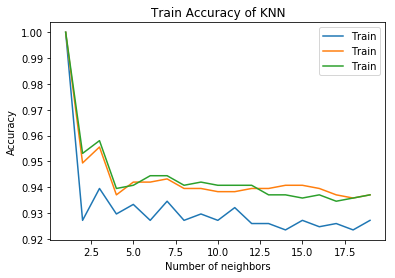

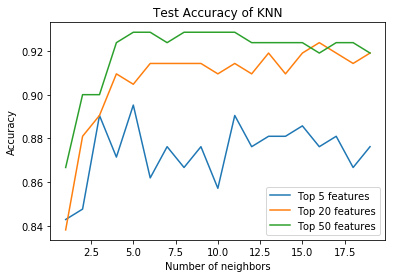

In [320]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in range(1,20):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict3:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    for nf in [5,20,50]:
        print("\t"+str(nf),end="\n")
        train_scores[d][nf], test_scores[d][nf]  = autoknn(data, nf, mode='knn')

import pickle

f = open("dump_10knntrainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10knntestscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

for d in data_dict3:
    print(d,end=":\n")
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(train_scores[d][nf].keys()), list(train_scores[d][nf].values()), label = "Train")
    plt.title("Train Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_train_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(test_scores[d][nf].keys()), list(test_scores[d][nf].values()), label = "Top "+str(nf) + " features")
    plt.title("Test Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_test_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();

prostate:
	5
	20
	50
prostate:


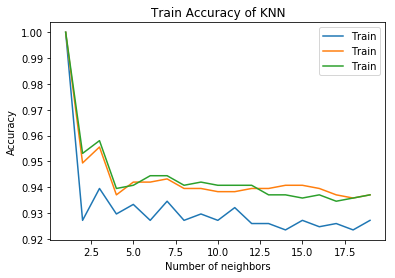

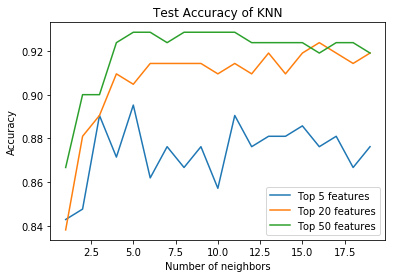

In [321]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in range(1,20):
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()

for d in data_dict3:
    train_scores[d] = dict()
    test_scores[d] = dict()
    
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    for nf in [5,20,50]:
        print("\t"+str(nf),end="\n")
        train_scores[d][nf], test_scores[d][nf]  = autoknn(data, nf, mode='knn')

import pickle

f = open("dump_10knntrainscores_recbest.pkl","wb")
pickle.dump(train_scores,f)

f = open("dump_10knntestscores_recbest.pkl","wb")
pickle.dump(test_scores,f)

f.close()

for d in data_dict3:
    print(d,end=":\n")
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(train_scores[d][nf].keys()), list(train_scores[d][nf].values()), label = "Train")
    plt.title("Train Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_train_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();
    
    plt.figure()
    for nf in [5,20,50]:
        plt.plot(list(test_scores[d][nf].keys()), list(test_scores[d][nf].values()), label = "Top "+str(nf) + " features")
    plt.title("Test Accuracy of KNN")
    plt.xlabel("Number of neighbors")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.savefig(str("Plots/knn_test_")+str(d)+"_"+str(nf)+".jpg"); 
    plt.show();

In [322]:
def autoknn(data, nf, mode= 'lr', f_sel="kbest"):
    train_scores = dict()
    test_scores = dict()
    kf = len(data.X_train)
    for kn in [5,10,20]:
        bfeat = feat_sel(data, nf, mode =f_sel)
        train_scores[kn] = 0.0
        test_scores[kn] = 0.0
        for i in range(kf):
            if mode =='knn':
                model = knnmodel(data,kn=kn, fid=i, feat=bfeat[i])
            train_acc, test_acc = calculate_accuracies(data.X_train[i], data.Y_train[i], data.X_test[i], data.Y_test[i], model, feature_indices=bfeat[i])
            train_scores[kn] += train_acc
            test_scores[kn] += test_acc
        train_scores[kn]/=kf
        test_scores[kn]/=kf
        #print(train_scores[kn],test_scores[kn])
    return train_scores, test_scores


train_scores = dict()
test_scores = dict()
    
for d in data_dict3:
    print(d,end=":\n")
    data = data_dict3[d]
    print(autoknn(data, nf, mode='knn', f_sel=None))



prostate:
({5: 0.9012345679012345, 10: 0.874074074074074, 20: 0.8345679012345679}, {5: 0.8333333333333333, 10: 0.819047619047619, 20: 0.7904761904761904})
